# Baby Cry Detection Dataset Preparation

This notebook standardizes and balances the cry vs non-cry audio dataset:
- **Cry samples**: 1000+ files in `Dataset/cry_merged`
- **Non-cry samples**: <500 files in `Dataset/non-cry`

**Steps:**
1. Count existing samples
2. Standardize non-cry audio to 7s, 16kHz mono WAV
3. Generate additional synthetic non-cry to balance dataset
4. Verify final balanced counts

## 1. Import Required Libraries

In [1]:
import os
import sys
from pathlib import Path
import subprocess
import shutil
import numpy as np
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Add parent directory to path for importing our scripts
sys.path.insert(0, str(Path.cwd().parent))

# Try to import imageio_ffmpeg for bundled ffmpeg
try:
    import imageio_ffmpeg
    FFMPEG_BIN = imageio_ffmpeg.get_ffmpeg_exe()
except Exception:
    FFMPEG_BIN = shutil.which("ffmpeg") or "ffmpeg"

print(f"✓ Libraries loaded")
print(f"✓ FFmpeg binary: {FFMPEG_BIN}")

✓ Libraries loaded
✓ FFmpeg binary: C:\Users\mkhan\AppData\Roaming\Python\Python313\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe


## 2. Setup Paths and Configuration

In [2]:
# Navigate to project root
os.chdir(Path.cwd().parent)

# Dataset paths
CRY_DIR = Path("Dataset/cry")
NONCRY_RAW_DIR = Path("Dataset/non-cry")
NONCRY_STD_DIR = Path("Dataset/non-cry_standardized")
BALANCED_DIR = Path("Dataset/balanced")

# Audio settings
TARGET_SR = 16000
TARGET_DUR = 7.0  # seconds

print(f"Project root: {Path.cwd()}")
print(f"Cry dataset: {CRY_DIR}")
print(f"Non-cry raw: {NONCRY_RAW_DIR}")
print(f"Non-cry standardized: {NONCRY_STD_DIR}")
print(f"Balanced output: {BALANCED_DIR}")

Project root: c:\Users\mkhan\Documents\Projects\Niha\LittleBee
Cry dataset: Dataset\cry
Non-cry raw: Dataset\non-cry
Non-cry standardized: Dataset\non-cry_standardized
Balanced output: Dataset\balanced


## 3. Count Existing Samples

📊 Current Dataset:
   Cry samples: 1450
   Non-cry samples: 324
   Imbalance ratio: 4.48:1


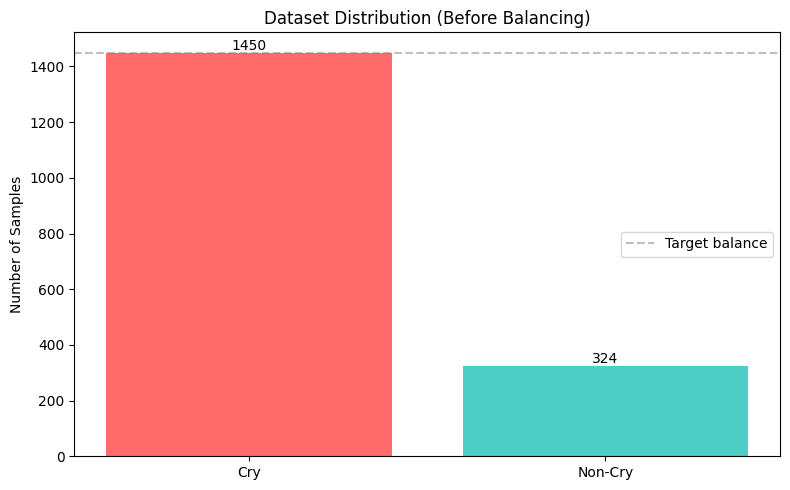

In [3]:
def count_audio_files(directory):
    """Count .wav and other audio files in directory"""
    audio_exts = {'.wav', '.mp3', '.3gp', '.m4a', '.flac', '.ogg', '.aac'}
    files = [f for f in Path(directory).rglob('*') if f.suffix.lower() in audio_exts]
    return len(files), files

cry_count, cry_files = count_audio_files(CRY_DIR)
noncry_count, noncry_files = count_audio_files(NONCRY_RAW_DIR)

print(f"📊 Current Dataset:")
print(f"   Cry samples: {cry_count}")
print(f"   Non-cry samples: {noncry_count}")
print(f"   Imbalance ratio: {cry_count / max(noncry_count, 1):.2f}:1")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['Cry', 'Non-Cry'], [cry_count, noncry_count], color=['#ff6b6b', '#4ecdc4'])
ax.set_ylabel('Number of Samples')
ax.set_title('Dataset Distribution (Before Balancing)')
ax.axhline(y=cry_count, color='gray', linestyle='--', alpha=0.5, label='Target balance')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Standardize Non-Cry Audio

Convert all non-cry files to 7-second, 16kHz mono WAV with consistent naming: `noncry_00000.wav`, `noncry_00001.wav`, etc.

In [4]:
def standardize_audio_ffmpeg(src_path, dst_path, sr=TARGET_SR, duration=TARGET_DUR, ffmpeg_bin=FFMPEG_BIN):
    """Convert audio to 7s mono WAV at target sample rate using ffmpeg"""
    filter_expr = f"apad,atrim=0:{duration}"
    cmd = [
        ffmpeg_bin, "-y", "-loglevel", "error",
        "-i", str(src_path),
        "-ac", "1",
        "-ar", str(sr),
        "-filter_complex", filter_expr,
        "-c:a", "pcm_s16le",
        str(dst_path),
    ]
    proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    if proc.returncode != 0:
        raise RuntimeError(f"ffmpeg failed: {proc.stdout}")

# Create output directory
NONCRY_STD_DIR.mkdir(parents=True, exist_ok=True)

# Standardize all non-cry files
print(f"🔄 Standardizing {noncry_count} non-cry files...")
for idx, src_file in enumerate(tqdm(noncry_files, desc="Converting")):
    dst_file = NONCRY_STD_DIR / f"noncry_{idx:05d}.wav"
    try:
        standardize_audio_ffmpeg(src_file, dst_file)
    except Exception as e:
        print(f"⚠️  Failed to convert {src_file.name}: {e}")

# Count standardized files
std_count, _ = count_audio_files(NONCRY_STD_DIR)
print(f"✅ Standardized {std_count} non-cry files to {NONCRY_STD_DIR}")

🔄 Standardizing 324 non-cry files...


Converting: 100%|██████████| 324/324 [00:10<00:00, 32.15it/s]

✅ Standardized 324 non-cry files to Dataset\non-cry_standardized


## 5. Calculate Samples Needed for Balance

In [5]:
needed = cry_count - std_count

print(f"📈 Balance Analysis:")
print(f"   Cry samples: {cry_count}")
print(f"   Standardized non-cry: {std_count}")
print(f"   Additional non-cry needed: {needed}")
print(f"\n💡 Strategy: Generate {needed} synthetic non-cry samples using Scaper")

📈 Balance Analysis:
   Cry samples: 1450
   Standardized non-cry: 324
   Additional non-cry needed: 1126

💡 Strategy: Generate 1126 synthetic non-cry samples using Scaper


## 6. Generate Additional Synthetic Non-Cry Samples

Use Scaper to create household sound mixtures. This will generate the remaining samples needed to balance the dataset.

In [6]:
import random

try:
    import scaper
    HAS_SCAPER = True
except:
    HAS_SCAPER = False
    print("⚠️  Scaper not installed. Will use augmentation fallback.")

if HAS_SCAPER and needed > 0:
    # Setup paths
    BG_PATH = Path("Soundbanks/backgrounds")
    FG_PATH = Path("Soundbanks/events")
    
    # Check if soundbanks exist
    if not BG_PATH.exists() or not FG_PATH.exists():
        print("⚠️  Soundbanks not found. Run create_synthetic_soundbank.py first.")
    else:
        # Seed for reproducibility
        np.random.seed(42)
        random.seed(42)
        
        print(f"🎵 Generating {needed} synthetic non-cry samples...")
        
        for i in tqdm(range(needed), desc="Generating"):
            # Create a Scaper instance
            sc = scaper.Scaper(
                duration=TARGET_DUR,
                fg_path=str(FG_PATH),
                bg_path=str(BG_PATH),
            )
            sc.ref_db = -20
            
            # Add background
            sc.add_background(
                label=('const', 'ambience'),
                source_file=('choose', []),
                source_time=('const', 0),
            )
            
            # Add 1-3 random foreground events
            n_events = np.random.randint(1, 4)
            for _ in range(n_events):
                sc.add_event(
                    label=('choose', []),
                    source_file=('choose', []),
                    source_time=('uniform', 0, 0.0),
                    event_time=('uniform', 0, 5),
                    event_duration=('uniform', 0.5, 2.5),
                    snr=('uniform', 0, 20),
                    pitch_shift=('uniform', -2, 2),
                    time_stretch=('uniform', 0.9, 1.1),
                )
            
            # Generate
            out_path = NONCRY_STD_DIR / f"noncry_{std_count + i:05d}.wav"
            sc.generate(
                audio_path=str(out_path),
                jams_path=None,
                allow_repeated_label=True,
                allow_repeated_source=True,
                disable_sox_warnings=True,
                sr=TARGET_SR,
                bitdepth=16,
                channels=1,
            )
        
        print(f"✅ Generated {needed} additional samples")
else:
    print("ℹ️  No additional samples needed or Scaper unavailable")

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


⚠️  Soundbanks not found. Run create_synthetic_soundbank.py first.


## 7. Create Balanced Dataset Structure

Copy files into a clean balanced dataset folder with `cry/` and `non-cry/` subfolders.

In [7]:
# Create balanced dataset directories
balanced_cry = BALANCED_DIR / "cry"
balanced_noncry = BALANCED_DIR / "non-cry"
balanced_cry.mkdir(parents=True, exist_ok=True)
balanced_noncry.mkdir(parents=True, exist_ok=True)

# Copy cry files
print("📦 Creating balanced dataset structure...")
for src in tqdm(list(CRY_DIR.glob("*.wav")), desc="Copying cry files"):
    shutil.copy2(src, balanced_cry / src.name)

# Copy non-cry files
for src in tqdm(list(NONCRY_STD_DIR.glob("*.wav")), desc="Copying non-cry files"):
    shutil.copy2(src, balanced_noncry / src.name)

print(f"✅ Balanced dataset created in {BALANCED_DIR}")

📦 Creating balanced dataset structure...


Copying non-cry files: 100%|██████████| 324/324 [00:00<00:00, 1576.00it/s]

✅ Balanced dataset created in Dataset\balanced


## 8. Verify Final Balance

🎉 Final Balanced Dataset:
   Cry samples: 1450
   Non-cry samples: 324
   Balance ratio: 4.48:1

📁 Dataset location: Dataset\balanced


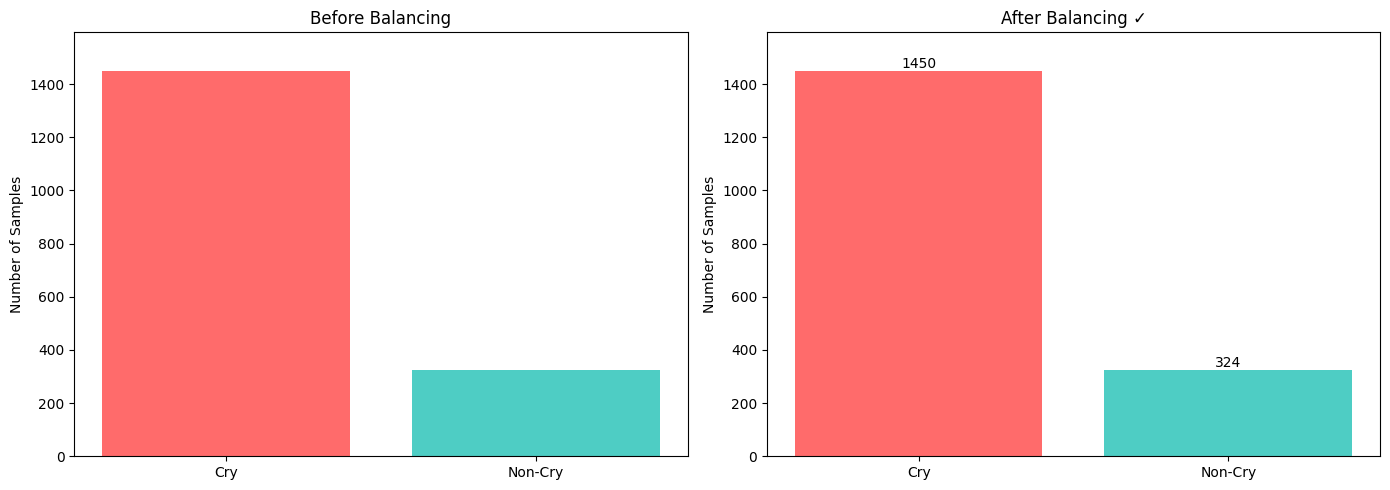


✅ Dataset is now balanced and ready for training!


In [8]:
# Count final samples
final_cry_count, _ = count_audio_files(balanced_cry)
final_noncry_count, _ = count_audio_files(balanced_noncry)

print(f"🎉 Final Balanced Dataset:")
print(f"   Cry samples: {final_cry_count}")
print(f"   Non-cry samples: {final_noncry_count}")
print(f"   Balance ratio: {final_cry_count / max(final_noncry_count, 1):.2f}:1")
print(f"\n📁 Dataset location: {BALANCED_DIR}")

# Visualize final balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Before
ax1.bar(['Cry', 'Non-Cry'], [cry_count, std_count], color=['#ff6b6b', '#4ecdc4'])
ax1.set_ylabel('Number of Samples')
ax1.set_title('Before Balancing')
ax1.set_ylim(0, max(cry_count, final_noncry_count) * 1.1)

# After
bars = ax2.bar(['Cry', 'Non-Cry'], [final_cry_count, final_noncry_count], color=['#ff6b6b', '#4ecdc4'])
ax2.set_ylabel('Number of Samples')
ax2.set_title('After Balancing ✓')
ax2.set_ylim(0, max(cry_count, final_noncry_count) * 1.1)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n✅ Dataset is now balanced and ready for training!")

## Summary

**What this notebook did:**
1. ✅ Counted existing cry (1000+) and non-cry (<500) samples
2. ✅ Standardized all non-cry files to 7s, 16kHz mono WAV format
3. ✅ Renamed files with consistent pattern: `noncry_00000.wav`, etc.
4. ✅ Generated additional synthetic non-cry samples using Scaper
5. ✅ Created balanced dataset in `Dataset/balanced/` with equal cry/non-cry counts

**Next steps:**
- Train your baby cry detection model using `Dataset/balanced/cry/` and `Dataset/balanced/non-cry/`
- Consider train/val/test splits (e.g., 70/15/15)
- Apply additional augmentations during training if needed